In [2]:
%matplotlib inline
import os, sys, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import auxFunctions as af
from collections import OrderedDict as OD
from ipywidgets import interact, interactive, fixed, widgets
from NotebookUtils.ProgressBar import LogProgress as LP
plt.rcParams['font.family']='serif'
plt.rcParams['font.weight']='light'
plt.rcParams['font.size']=14
figsize = (12,8)

# List for files, channels and masses settings
evFiles = ['../Output/'+name for name in os.listdir('../Output/') if 'hepevt' in name[-6:]]
masses = [float(name.split('mass')[1].split('_')[0]) for name in evFiles]
channels = [int(name.split('channel')[1].split('_')[0]) for name in evFiles]
wMasses = dict(('%s' %mass, mass) for mass in set(masses))
wChannels = dict(('%s' %channel, channel) for channel in set(channels))

# Physics variables
nsPerTick = 15.6 # Nanoseconds per tick
triggerStart = 190 * nsPerTick # Trigger start time in ticks (as of config file)
bnbDuration = 120 * nsPerTick # BNB trigger duration in ticks (as of config file)
hsnDuration = (160 * nsPerTick) - bnbDuration # HSN trigger additional duration in ticks (as of config file)

print hsnDuration

nuArrival = 3125 # Time of BNB neutrinos arrival in nanoseconds
beamGate = 1600 # Beam gate window in nanoseconds

bnbRange = [triggerStart,triggerStart+bnbDuration]
hsnRange = [triggerStart+bnbDuration,triggerStart+bnbDuration+hsnDuration]

# Functions
def NormHist(data,bins,rangex,norm=1.):
    hist,bins = np.histogram(data,bins=bins,range=rangex)
    bins = bins[:-1]
    if norm == 'Int':
        norm = float(hist.sum())
    hist = hist/float(norm)
    return bins,hist

def PseudoNuDistribution():
    dist = np.random.uniform(nuArrival,nuArrival+beamGate,100000)
    bins,hist = NormHist(dist,100,[0,10000],'Int')
    return bins,hist

def DfDistribution(df,column,rangex):
    hist,bins = np.histogram([[df[column][i][0]] for i in range(len(df))],bins=100,range=rangex)
    bins = bins[:-1]
    hist = hist/float(hist.sum())
    return bins,hist

# Settings
channel = 2
mass = 0.37

print masses

624.0
[0.141, 0.16, 0.3, 0.49, 0.246, 0.26, 0.37, 0.49]


# Timing information
Information about time of arrival of heavy sterile neutrinos and event fractions falling in each trigger

In [24]:
%%time
# Get timing histogram
fileName = '../Output/sterileEvents_channel%i_mass%s_n50000.hepevt' %(channel,mass)
df = af.Hepevt2Pandas(fileName)

bins, hist = DfDistribution(df,'Time',[0,10000])
pdbins, pdhist = PseudoNuDistribution()
time = pd.Series([df['Time'][i][0] for i in range(len(df))])

bnbEvents = [(time > bnbRange[0]) & (time <= bnbRange[1])]
bnbFrac = len(df['Energy'].values[bnbEvents])/float(len(df))*100.

hsnEvents = [(time > hsnRange[0]) & (time <= hsnRange[1])]
hsnFrac = len(df['Energy'].values[hsnEvents])/float(len(df))*100.

CPU times: user 4.72 s, sys: 200 ms, total: 4.92 s
Wall time: 5.55 s


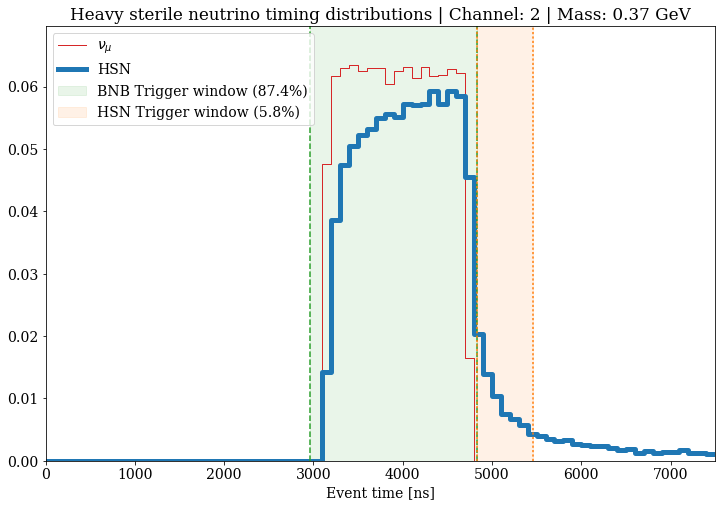

In [25]:
fig = plt.figure(figsize=figsize)
plt.step(pdbins,pdhist,where='post',color='C3',lw=1,label=r'$\nu_{\mu}$')
plt.step(bins,hist,where='post',color='C0',lw=5,label='HSN')
plt.axvline(bnbRange[0],color='C2',ls='--')
plt.axvline(bnbRange[1],color='C2',ls='--')
plt.axvline(hsnRange[0],color='C1',ls=':')
plt.axvline(hsnRange[1],color='C1',ls=':')
plt.fill_between([bnbRange[0],bnbRange[1]],[1,1],color='C2',alpha=0.1,label='BNB Trigger window (%.1f%%)' %bnbFrac)
plt.fill_between([hsnRange[0],hsnRange[1]],[1,1],color='C1',alpha=0.1, label='HSN Trigger window (%.1f%%)' %hsnFrac)
yMax = max(max(hist),max(pdhist))
plt.xlim(0,7500)
plt.ylim(0,yMax*1.1)
plt.title('Heavy sterile neutrino timing distributions | Channel: %s | Mass: %s GeV' %(channel,mass))
plt.xlabel('Event time [ns]')
plt.legend(loc='best')
plt.show()

# Energy distributions
For each decay particle and each trigger

In [26]:
%%time
# Energy distributions for decay particles in BNB trigger window
bnbEnergy = df['Energy'].values[bnbEvents]
hsnEnergy = df['Energy'].values[hsnEvents]

# Select trigger type for muons
bnbEnergy_mu = [bnbEnergy[i][0] for i in range(len(bnbEnergy))]
hsnEnergy_mu = [hsnEnergy[i][0] for i in range(len(hsnEnergy))]
totEnergy_mu = [df['Energy'][i][0] for i in range(len(df))]

# Select trigger type for pions
bnbEnergy_pi = [bnbEnergy[i][1] for i in range(len(bnbEnergy))]
hsnEnergy_pi = [hsnEnergy[i][1] for i in range(len(hsnEnergy))]
totEnergy_pi = [df['Energy'][i][1] for i in range(len(df))]

CPU times: user 2.39 s, sys: 68.8 ms, total: 2.46 s
Wall time: 2.55 s


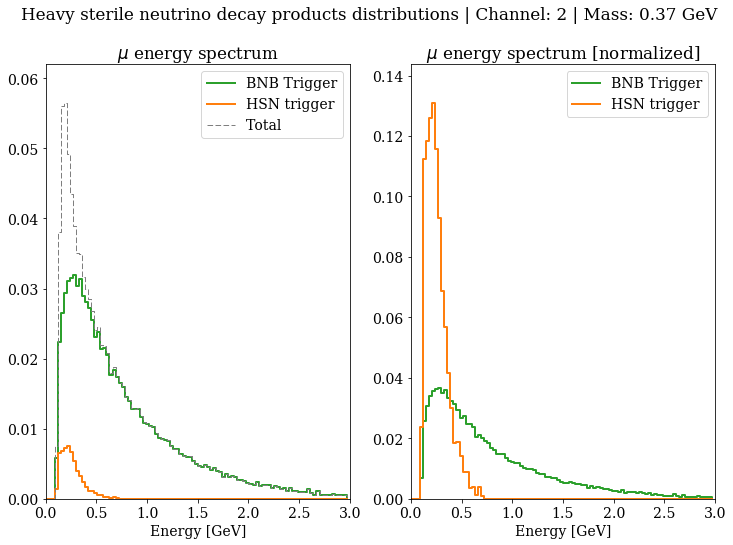

In [27]:
# Calculate histograms
bins, totMu_hist = NormHist(totEnergy_mu,100,[0,3],'Int')
bins, bnbMu_hist = NormHist(bnbEnergy_mu,100,[0,3],len(df))
bins, hsnMu_hist = NormHist(hsnEnergy_mu,100,[0,3],len(df))
bins, bnbMu_hist_norm = NormHist(bnbEnergy_mu,100,[0,3],'Int')
bins, hsnMu_hist_norm = NormHist(hsnEnergy_mu,100,[0,3],'Int')

# Plot histograms
fig,(ax1,ax2) = plt.subplots(1,2,figsize=figsize)
plt.suptitle('Heavy sterile neutrino decay products distributions | Channel: %s | Mass: %s GeV' %(channel,mass))

ax1.step(bins,bnbMu_hist,where='post',color='C2',lw=2,label='BNB Trigger')
ax1.step(bins,hsnMu_hist,where='post',color='C1',lw=2,label='HSN trigger')
ax1.step(bins,totMu_hist,where='post',color='C7',linestyle='--',lw=1,label='Total')
yMax = max(max(bnbMu_hist),max(hsnMu_hist),max(totMu_hist))
ax1.set_xlim(0,3)
ax1.set_ylim(0,yMax*1.1)
ax1.set_xlabel('Energy [GeV]')
ax1.legend(loc='best')
ax1.set_title(r'$\mu$ energy spectrum')

ax2.step(bins,bnbMu_hist_norm,where='post',color='C2',lw=2,label='BNB Trigger')
ax2.step(bins,hsnMu_hist_norm,where='post',color='C1',lw=2,label='HSN trigger')
yMax = max(max(bnbMu_hist_norm),max(hsnMu_hist_norm))
ax2.set_xlim(0,3)
ax2.set_ylim(0,yMax*1.1)
ax2.set_xlabel('Energy [GeV]')
ax2.legend(loc='best')
ax2.set_title(r'$\mu$ energy spectrum [normalized]')

plt.show()

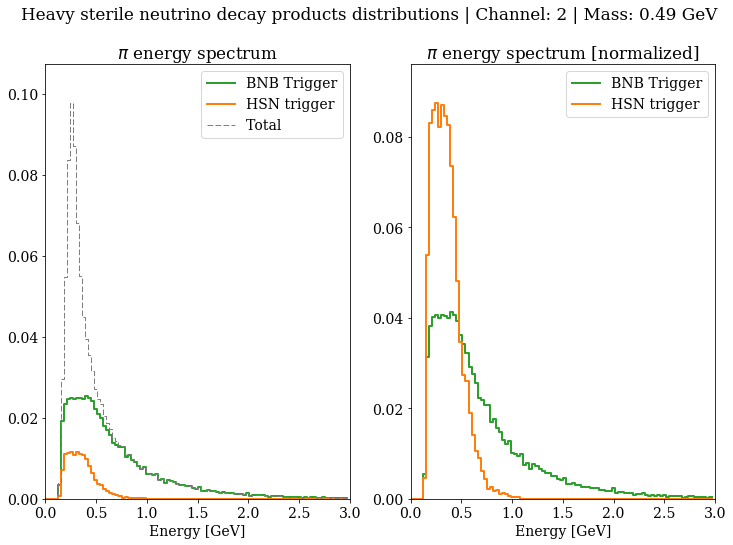

In [233]:
# Calculate histograms
bins, totPi_hist = NormHist(totEnergy_pi,100,[0,3],'Int')
bins, bnbPi_hist = NormHist(bnbEnergy_pi,100,[0,3],len(df))
bins, hsnPi_hist = NormHist(hsnEnergy_pi,100,[0,3],len(df))
bins, bnbPi_hist_norm = NormHist(bnbEnergy_pi,100,[0,3],'Int')
bins, hsnPi_hist_norm = NormHist(hsnEnergy_pi,100,[0,3],'Int')

# Plot histograms
fig,(ax1,ax2) = plt.subplots(1,2,figsize=figsize)
plt.suptitle('Heavy sterile neutrino decay products distributions | Channel: %s | Mass: %s GeV' %(channel,mass))

ax1.step(bins,bnbPi_hist,where='post',color='C2',lw=2,label='BNB Trigger')
ax1.step(bins,hsnPi_hist,where='post',color='C1',lw=2,label='HSN trigger')
ax1.step(bins,totPi_hist,where='post',color='C7',linestyle='--',lw=1,label='Total')
yMax = max(max(bnbPi_hist),max(hsnPi_hist),max(totPi_hist))
ax1.set_xlim(0,3)
ax1.set_ylim(0,yMax*1.1)
ax1.set_xlabel('Energy [GeV]')
ax1.legend(loc='best')
ax1.set_title(r'$\pi$ energy spectrum')

ax2.step(bins,bnbPi_hist_norm,where='post',color='C2',lw=2,label='BNB Trigger')
ax2.step(bins,hsnPi_hist_norm,where='post',color='C1',lw=2,label='HSN trigger')
yMax = max(max(bnbPi_hist_norm),max(hsnPi_hist_norm))
ax2.set_xlim(0,3)
ax2.set_ylim(0,yMax*1.1)
ax2.set_xlabel('Energy [GeV]')
ax2.legend(loc='best')
ax2.set_title(r'$\pi$ energy spectrum [normalized]')

plt.show()

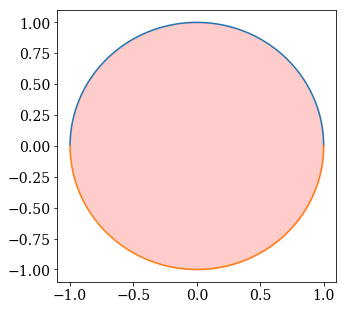

In [17]:
r = 1
x = np.linspace(-1,1,1000)
y1 = np.sqrt(np.power(r,2.) - np.power(x,2.))
y2 = -1*np.sqrt(np.power(r,2.) - np.power(x,2.))


fig = plt.figure(figsize=(5,5))
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2,color='red',alpha=0.2)